# Dataworth with Freyberg Pilot Points Model

### Here we are going to investigate the sources of forecast uncertainty as well as the worth of observations to reduce forecast uncertainty.  This is essentially the same workflow as used with the ``freyberg_zone_dataworth`` excersize.  Important things to remember:
### - FOSM doesn't require values for observations, parameters or forecast.  We do need sensitivities between the quantities and estimates of prior uncertainties for parameters and observtion noise.  
- 

In [1]:
%matplotlib inline
import os
import sys
sys.path.append("..")
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu

In [2]:
import freyberg_setup as fs
fs.setup_pest_pp()
working_dir = fs.WORKING_DIR_PP
pst_name = fs.PST_NAME_PP

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...

changing model workspace...
   freyberg_pp
FloPy is using the following executable to run the model: /Users/jeremyw/Dev/gw1876/activities/freyberg_pilot_points_dataworth/freyberg_pp/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.1, 7/21/2016                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.04.0 07/21/2016                       

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/04/18 16:30:52

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:  

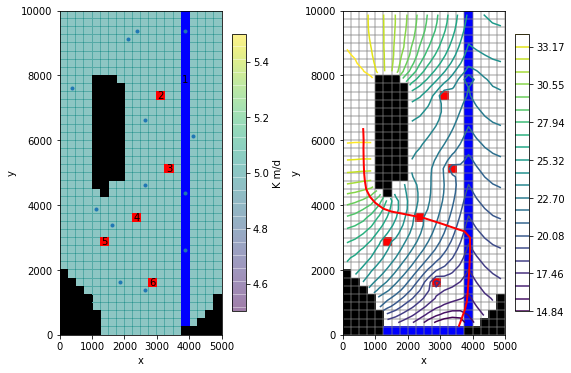

In [3]:
fs.plot_model(working_dir, pst_name)

In [4]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
par = pst.parameter_data
par.loc[par.parnme.apply(lambda x: x.startswith("w")),"partrans"] = "fixed"
pst.control_data.noptmax = -1
pst.write(os.path.join(working_dir,pst_name))


In [5]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.',"pestpp",pst_name,num_slaves=15,master_dir=".")
os.chdir("..")

In [6]:
sc = pyemu.Schur(os.path.join(working_dir,pst_name.replace(".pst",".jcb")))

### A quick check of which parameters are being informed by the observations during calibration:

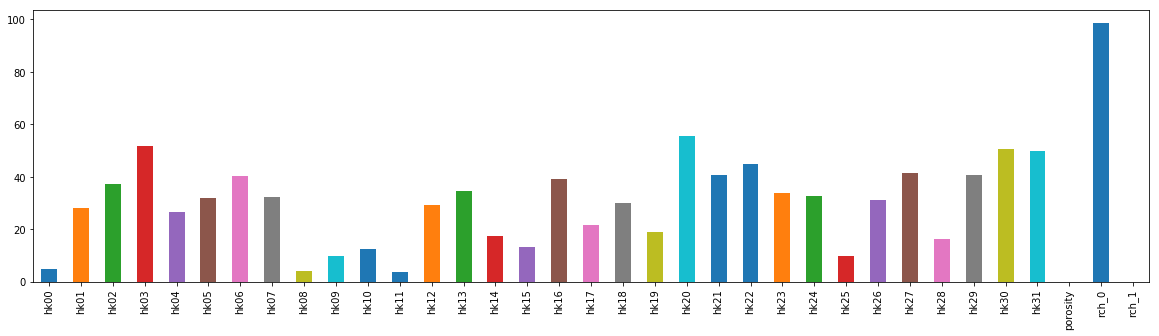

In [7]:
fig = plt.figure(figsize=(20,5))
ax = plt.subplot(111)
sc.get_parameter_summary().percent_reduction.plot(kind="bar",ax=ax)

## Parameter contribution analysis

### We are going to use the ``Schur.get_par_contribution()`` method. It calculates the *decrease* in forecast uncertainty resulting for hypothetical "perfect knowledge" (no uncertainty) of arbitrary groups of parameters. If you don't pass any arguments, then it tests each parameter independently:

In [8]:
df_pc = sc.get_par_contribution()


In [9]:
df_pc = 100.0 * (1.0 - df_pc / df_pc.loc["base",:])

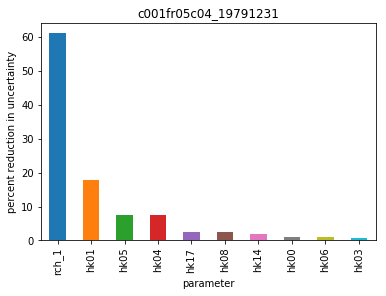

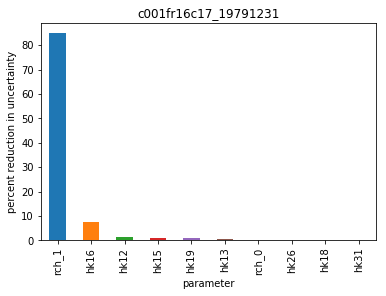

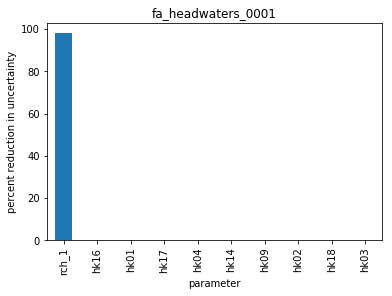

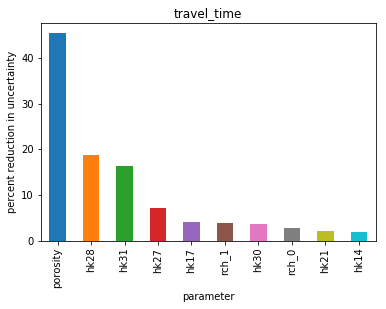

In [10]:
for forecast in df_pc.columns:
    ax = df_pc.sort_values(by=forecast,ascending=False).loc[:,forecast].iloc[:10].plot(kind="bar")
    ax.set_title(forecast)
    ax.set_ylabel("percent reduction in uncertainty")
    ax.set_xlabel("parameter")
    plt.show()

### We see a mixture of HK pilot points, recharge, and well pumping rates...so we see that each forecast depends on (potentailly) difference combinations of parameters.  Does this mean we can still make a model that makes several kinds of forecasts???

## Observation worth

### Let's see what observations are most important to the forecasts.  We will start be investigating the value of the existing observations using the ``Schur.get_removed_obs_importance()`` method.  It calculates the *increase* in forecast uncertainty that happens if we lose each existing observation. We will start with the existing observations:

In [11]:
df_rm = sc.get_removed_obs_importance()
df_rm

,c001fr05c04_19791231,c001fr16c17_19791231,fa_headwaters_0001,travel_time
base,1.890346,0.123295,371046.680483,5.819654e+07
c001cr27c07_19700102,1.894269,0.123857,371350.540989,5.971430e+07
c001cr03c10_19700102,2.019024,0.123313,371101.317025,5.823969e+07
c001cr25c05_19700102,1.897918,0.123438,371315.877794,5.840157e+07
c001cr34c08_19700102,1.890853,0.123334,371054.019897,6.110753e+07
c001cr22c11_19700102,1.890350,0.125558,371730.773350,5.829132e+07
c001cr23c16_19700102,1.890790,0.123319,371051.503000,5.979112e+07
c001cr16c17_19700102,1.890349,0.137350,372652.300585,5.823585e+07
c001cr30c16_19700102,1.894127,0.123304,371203.126180,5.975088e+07
c001cr35c11_19700102,1.897197,0.123368,371557.799183,7.606333e+07


In [12]:
df_rm = 100.0 * (1.0 - df_rm.loc["base",:] / df_rm)

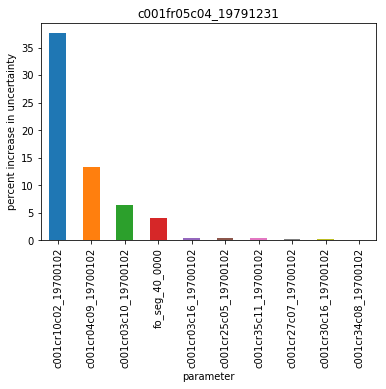

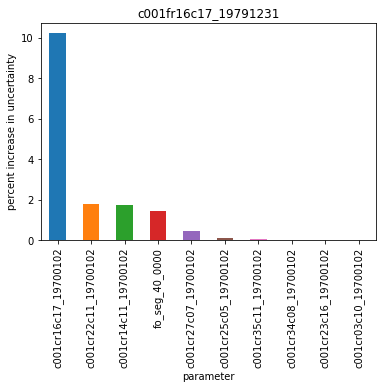

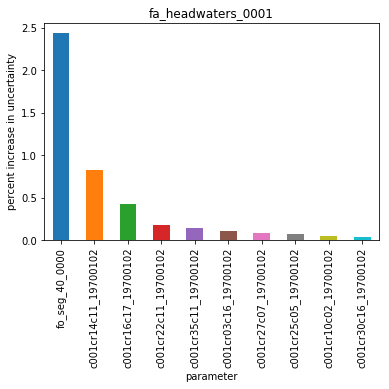

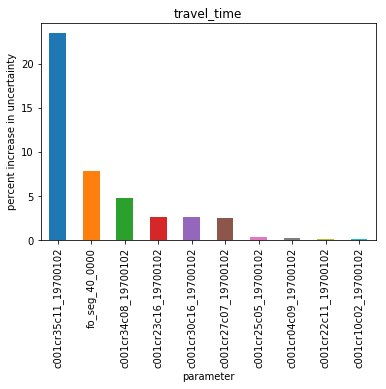

In [13]:
for forecast in df_rm.columns:
    ax = df_rm.sort_values(by=forecast,ascending=False).loc[:,forecast].iloc[:10].plot(kind="bar")
    ax.set_title(forecast)
    ax.set_ylabel("percent increase in uncertainty")
    ax.set_xlabel("parameter")
    plt.show()

### Estimating the value of yet-to-be-collected observations

### Using the assumptions of FOSM, we can also calculate the value of observations we don't have yet!  Black magic!  

### Not really, we carried these possible data locations as ``observations`` in the control file - this means each one has a row in the jacobian (just like any other output of interest).  If we then assume some value of measurement noise (a non-zero weight in the control file), we can run a hypothetical "calibration" analysis using Schur compliment.  Remember, FOSM doesn't care about actual values of parameters, observations, or forecasts, only sensitivities...

### In pyemu, the ``Schur.get_added_obs_importance()`` method calculates the *decrease* in uncertainty resulting for having new obsevations during calibration.  It accepts an optional argument ``obslist_dict`` which is a python dictionary of groups of new observations to test.  

### Here we will test the value of having the water level in each unmeasured model cell.  Then we can make maps of where to collect new data...these calculations take a little while to run because we are repeatedly calculating the entire FOSM process for each new observation location 

In [14]:
pobs_names = [o for o in sc.pst.obs_names if "pr" in o and "19700102" in o]
df_ad = sc.get_added_obs_importance(obslist_dict={oname:oname for oname in pobs_names},
                                base_obslist=sc.pst.nnz_obs_names,reset_zero_weight=5.0)

In [15]:
df_ad.min()

c001fr05c04_19791231    1.214126e+00
c001fr16c17_19791231    1.118612e-01
fa_headwaters_0001      3.690346e+05
travel_time             3.772234e+07
dtype: float64

In [16]:
df_ad.max()

c001fr05c04_19791231    1.890346e+00
c001fr16c17_19791231    1.232948e-01
fa_headwaters_0001      3.710467e+05
travel_time             5.819654e+07
dtype: float64

In [17]:
# just a helper function to make maps of data worth
m = flopy.modflow.Modflow.load(fs.MODEL_NAM,model_ws=working_dir)
obs = pst.observation_data
hobs = obs.loc[obs.obgnme=="calhead",:].copy()
hobs.loc[:,"i"] = hobs.obsnme.apply(lambda x: int(x[6:8])-1)
hobs.loc[:,"j"] = hobs.obsnme.apply(lambda x: int(x.split('_')[0].split('c')[-1])-1)
hobs.loc[:,"x"] = m.sr.xcentergrid[hobs.i,hobs.j]
hobs.loc[:,"y"] = m.sr.ycentergrid[hobs.i,hobs.j]
wdata = pd.DataFrame.from_records(m.wel.stress_period_data[0])
wdata.loc[:,"x"] = m.sr.xcentergrid[wdata.i,wdata.j]
wdata.loc[:,"y"] = m.sr.ycentergrid[wdata.i,wdata.j]
pp_df = pyemu.pp_utils.pp_file_to_dataframe(os.path.join(working_dir,"hkpp.dat"))
def plot_added_worth(df):
    df_base = df.loc["base",:]
    df_frac = 100.0 * (1.0 - (df / df_base))
    df_frac = df_frac.loc[pobs_names,:]
    df_frac.loc[:,"i"] = df_frac.index.map(lambda x: int(x[6:8])-1)
    df_frac.loc[:,"j"] = df_frac.index.map(lambda x: int(x[9:11])-1)
    #print(df_frac.)
    for forecast in sc.pst.forecast_names:
        print(forecast)
        arr = np.zeros((m.nrow,m.ncol)) - 1
        arr[df_frac.i,df_frac.j] = df_frac.loc[:,forecast]
        arr = np.ma.masked_where(arr < 0.0 ,arr)
        fig = plt.figure(figsize=(12,10))
        
        ax = plt.subplot(111,aspect="equal")
        c = ax.pcolormesh(m.sr.xedge,m.sr.yedge,arr,alpha=0.75)
        plt.colorbar(c)
        #if forecast.startswith("fr"):
        #    i = int(forecast[2:4]) - 1
        #    j = int(forecast.split('_')[0].split('c')[-1]) - 1
        #    x,y = m.sr.xcentergrid[i,j],m.sr.ycentergrid[i,j]
        #    ax.scatter([x],[y],marker='o',color='r',s=150)
            #ax2.scatter([x],[y],marker='o',color='r',s=150)    
        ax.scatter(hobs.x,hobs.y,marker='x',s=100,color='y')
        ax.scatter(wdata.x,wdata.y,marker='*',s=100,color='m')
        ax.scatter(pp_df.x,pp_df.y,marker='.',color='w',s=50)
        ax.set_title(forecast)
        
        plt.show()
        plt.close(fig)
    

### Now we are going to plot the worth (reduction in uncertainty) of a single, new water level measurement for each forecast (forecast name is the title of each plot). So these plots show us where to go collect new data to reduce forecast uncertainty as much as possible...red circles show the forecast (for water level forecasts), yellow X's are the locations of existing water levels, purple stars mark pumping well locations (pumping rates are treated as uncertain!)

travel_time


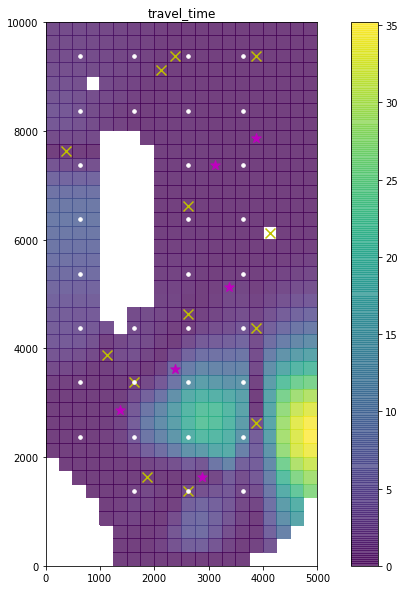

fa_headwaters_0001


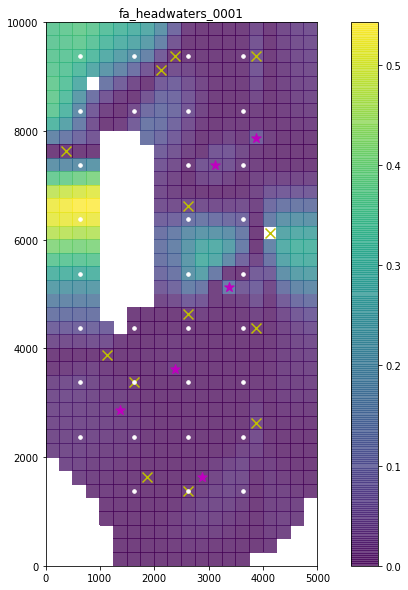

c001fr16c17_19791231


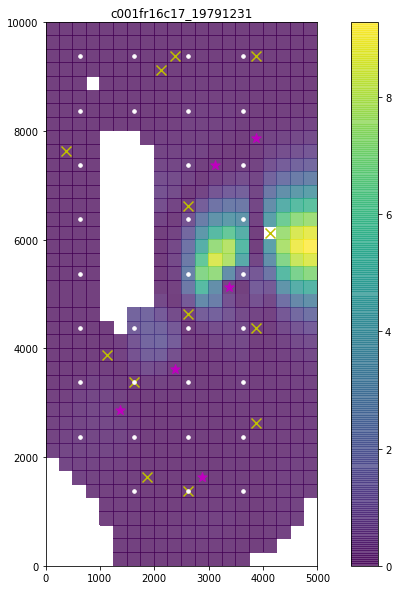

c001fr05c04_19791231


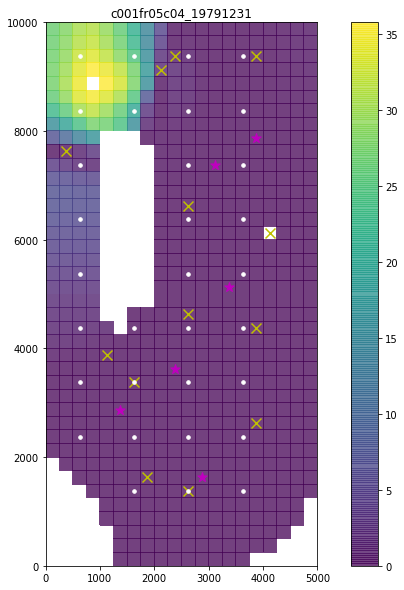

In [18]:
plot_added_worth(df_ad)

In [19]:
sc.pst.nnz_obs_names

['c001cr03c10_19700102',
 'c001cr03c16_19700102',
 'c001cr04c09_19700102',
 'c001cr10c02_19700102',
 'c001cr14c11_19700102',
 'c001cr16c17_19700102',
 'c001cr22c11_19700102',
 'c001cr23c16_19700102',
 'c001cr25c05_19700102',
 'c001cr27c07_19700102',
 'c001cr30c16_19700102',
 'c001cr34c08_19700102',
 'c001cr35c11_19700102',
 'fo_seg_40_0000']

Ok, so those are cool.  And, unlike the zoned-parameterization dataworth, these make sense from a physical interpretation standpoint

Let's explore what happens when we use a full covariance prior

In [20]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=2500.0)
gs = pyemu.geostats.GeoStruct(variograms=[v])
cov = pyemu.helpers.pilotpoint_prior_builder(sc.pst,
                            struct_dict={gs:os.path.join(working_dir,"hkpp.dat.tpl")})

/Users/jeremyw/Dev/pyemu/pyemu/utils/helpers.py:100: UserWarning: 'pilotpoint_prior_builder' has been renamed to 'geostatistical_prior_builder'
  "'geostatistical_prior_builder'")


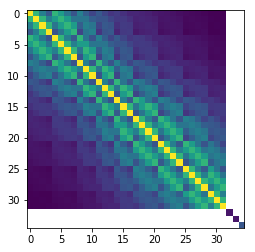

In [21]:
x = np.ma.masked_where(cov.x==0,cov.x)
plt.imshow(x)

In [22]:
sc_full = pyemu.Schur(jco=sc.jco,pst=sc.pst,parcov=cov,forecasts=sc.forecasts,verbose=True)

2018-04-18 16:31:37.885061 starting: pre-loading base components
2018-04-18 16:31:37.885174 starting: loading obscov
2018-04-18 16:31:37.973471 finished: loading obscov took: 0:00:00.088297
2018-04-18 16:31:37.973557 starting: loading forecasts
2018-04-18 16:31:37.975077 finished: loading forecasts took: 0:00:00.001520
2018-04-18 16:31:37.975135 forecast names: travel_time,fa_headwaters_0001,c001fr16c17_19791231,c001fr05c04_19791231
2018-04-18 16:31:37.975156 finished: pre-loading base components took: 0:00:00.090095
2018-04-18 16:31:37.975186 starting: dropping prior information
2018-04-18 16:31:37.976478 starting: removing 0 prior info from jco, pst, and obs cov
2018-04-18 16:31:37.978500 finished: removing 0 prior info from jco, pst, and obs cov took: 0:00:00.002022
2018-04-18 16:31:37.978559 finished: dropping prior information took: 0:00:00.003373


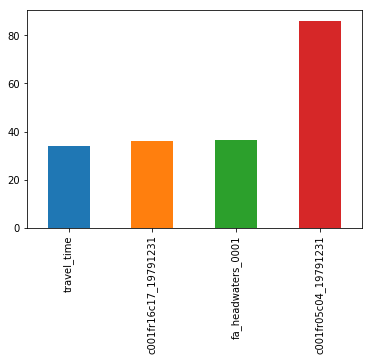

In [23]:
sc.get_forecast_summary().sort_values(by='percent_reduction').percent_reduction.plot(kind="bar")

In [24]:
df_full = sc_full.get_forecast_summary()
df_full.loc[:,"full"] = df_full.percent_reduction
df_full.loc[:,"diag"] = sc.get_forecast_summary().percent_reduction

2018-04-18 16:31:38.118504 starting: propagating prior to predictions
2018-04-18 16:31:38.125433 finished: propagating prior to predictions took: 0:00:00.006929
2018-04-18 16:31:38.125521 starting: propagating posterior to predictions
2018-04-18 16:31:38.125897 starting: Schur's complement
2018-04-18 16:31:38.126518 starting: xtqx
2018-04-18 16:31:38.172249 finished: xtqx took: 0:00:00.045731
2018-04-18 16:31:38.172788 finished: Schur's complement took: 0:00:00.046891
2018-04-18 16:31:38.173121 finished: propagating posterior to predictions took: 0:00:00.047600


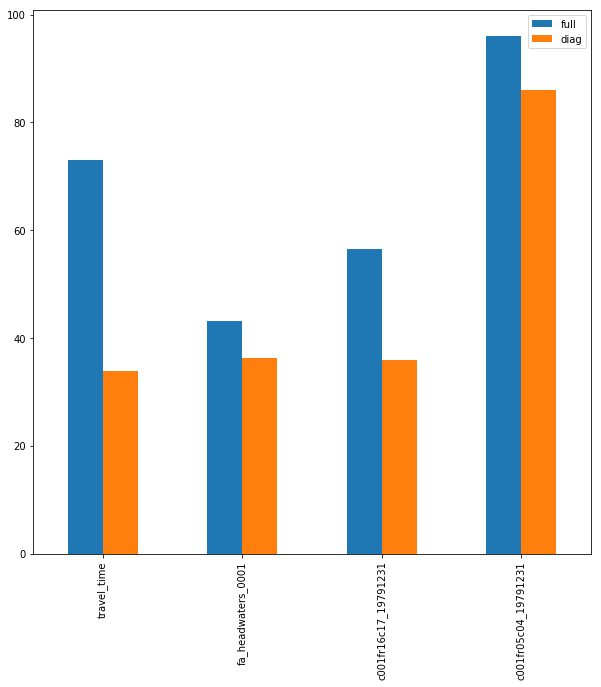

In [25]:
df_full.loc[:,["full","diag"]].plot(kind="bar",figsize=(10,10))

### Why did percent reduction increase for all forecasts increase???

In [26]:
df_full.prior_var

travel_time             1.936158e+08
fa_headwaters_0001      6.516233e+05
c001fr16c17_19791231    2.638126e-01
c001fr05c04_19791231    4.258618e+01
Name: prior_var, dtype: float64

In [27]:
sc.get_forecast_summary().prior_var

travel_time             8.811970e+07
fa_headwaters_0001      5.829228e+05
c001fr16c17_19791231    1.922666e-01
c001fr05c04_19791231    1.355823e+01
Name: prior_var, dtype: float64

### Let's recalculate the value of possible new observations...this takes longer now that we are using a full covaraince matrix because the repeated matrix-matrix products...

In [28]:
df_full = sc_full.get_added_obs_importance(obslist_dict={oname:oname for oname in pobs_names},
                                base_obslist=sc.pst.nnz_obs_names,reset_zero_weight=5.0)

2018-04-18 16:31:38.400928 resetting zero weights to 5.0
2018-04-18 16:31:38.411069 starting: resetting zero weight obs in base_obslist
2018-04-18 16:31:38.432944 finished: resetting zero weight obs in base_obslist took: 0:00:00.021875
2018-04-18 16:31:38.434441 starting: resetting zero weight obs in obslist_dict
2018-04-18 16:31:38.466770 finished: resetting zero weight obs in obslist_dict took: 0:00:00.032329
2018-04-18 16:31:38.466841 starting: resetting self.obscov
2018-04-18 16:31:38.466915 WARNING: resetting obscov
2018-04-18 16:31:38.466983 finished: resetting self.obscov took: 0:00:00.000142
2018-04-18 16:31:38.467223 starting: loading obscov
2018-04-18 16:31:38.545361 finished: loading obscov took: 0:00:00.078138
2018-04-18 16:31:38.558643 starting: calculating importance of observations by adding: ['c001pr37c16_19700102']

2018-04-18 16:31:38.573815 finished: calculating importance of observations by adding: ['c001pr37c16_19700102']
 took: 0:00:00.015172
2018-04-18 16:31:38.5

2018-04-18 16:31:39.059606 finished: calculating importance of observations by adding: ['c001pr10c18_19700102']
 took: 0:00:00.015794
2018-04-18 16:31:39.059665 starting: calculating importance of observations by adding: ['c001pr13c02_19700102']

2018-04-18 16:31:39.074896 finished: calculating importance of observations by adding: ['c001pr13c02_19700102']
 took: 0:00:00.015231
2018-04-18 16:31:39.074956 starting: calculating importance of observations by adding: ['c001pr10c09_19700102']

2018-04-18 16:31:39.089877 finished: calculating importance of observations by adding: ['c001pr10c09_19700102']
 took: 0:00:00.014921
2018-04-18 16:31:39.089994 starting: calculating importance of observations by adding: ['c001pr12c19_19700102']

2018-04-18 16:31:39.105064 finished: calculating importance of observations by adding: ['c001pr12c19_19700102']
 took: 0:00:00.015070
2018-04-18 16:31:39.105121 starting: calculating importance of observations by adding: ['c001pr24c02_19700102']

2018-04-18 1

2018-04-18 16:31:39.738765 finished: calculating importance of observations by adding: ['c001pr08c05_19700102']
 took: 0:00:00.015228
2018-04-18 16:31:39.738816 starting: calculating importance of observations by adding: ['c001pr14c01_19700102']

2018-04-18 16:31:39.754277 finished: calculating importance of observations by adding: ['c001pr14c01_19700102']
 took: 0:00:00.015461
2018-04-18 16:31:39.754340 starting: calculating importance of observations by adding: ['c001pr18c19_19700102']

2018-04-18 16:31:39.769636 finished: calculating importance of observations by adding: ['c001pr18c19_19700102']
 took: 0:00:00.015296
2018-04-18 16:31:39.769777 starting: calculating importance of observations by adding: ['c001pr14c19_19700102']

2018-04-18 16:31:39.785830 finished: calculating importance of observations by adding: ['c001pr14c19_19700102']
 took: 0:00:00.016053
2018-04-18 16:31:39.785896 starting: calculating importance of observations by adding: ['c001pr30c18_19700102']

2018-04-18 1

2018-04-18 16:31:40.397719 finished: calculating importance of observations by adding: ['c001pr30c09_19700102']
 took: 0:00:00.015536
2018-04-18 16:31:40.397784 starting: calculating importance of observations by adding: ['c001pr31c18_19700102']

2018-04-18 16:31:40.413259 finished: calculating importance of observations by adding: ['c001pr31c18_19700102']
 took: 0:00:00.015475
2018-04-18 16:31:40.413395 starting: calculating importance of observations by adding: ['c001pr03c07_19700102']

2018-04-18 16:31:40.428733 finished: calculating importance of observations by adding: ['c001pr03c07_19700102']
 took: 0:00:00.015338
2018-04-18 16:31:40.428978 starting: calculating importance of observations by adding: ['c001pr39c10_19700102']

2018-04-18 16:31:40.444926 finished: calculating importance of observations by adding: ['c001pr39c10_19700102']
 took: 0:00:00.015948
2018-04-18 16:31:40.444992 starting: calculating importance of observations by adding: ['c001pr12c02_19700102']

2018-04-18 1

2018-04-18 16:31:41.055659 finished: calculating importance of observations by adding: ['c001pr33c16_19700102']
 took: 0:00:00.012468
2018-04-18 16:31:41.055710 starting: calculating importance of observations by adding: ['c001pr16c11_19700102']

2018-04-18 16:31:41.067444 finished: calculating importance of observations by adding: ['c001pr16c11_19700102']
 took: 0:00:00.011734
2018-04-18 16:31:41.067490 starting: calculating importance of observations by adding: ['c001pr24c08_19700102']

2018-04-18 16:31:41.079413 finished: calculating importance of observations by adding: ['c001pr24c08_19700102']
 took: 0:00:00.011923
2018-04-18 16:31:41.079465 starting: calculating importance of observations by adding: ['c001pr11c01_19700102']

2018-04-18 16:31:41.091456 finished: calculating importance of observations by adding: ['c001pr11c01_19700102']
 took: 0:00:00.011991
2018-04-18 16:31:41.091513 starting: calculating importance of observations by adding: ['c001pr27c19_19700102']

2018-04-18 1

2018-04-18 16:31:41.719588 finished: calculating importance of observations by adding: ['c001pr38c11_19700102']
 took: 0:00:00.015608
2018-04-18 16:31:41.719636 starting: calculating importance of observations by adding: ['c001pr01c20_19700102']

2018-04-18 16:31:41.733383 finished: calculating importance of observations by adding: ['c001pr01c20_19700102']
 took: 0:00:00.013747
2018-04-18 16:31:41.733436 starting: calculating importance of observations by adding: ['c001pr15c16_19700102']

2018-04-18 16:31:41.748814 finished: calculating importance of observations by adding: ['c001pr15c16_19700102']
 took: 0:00:00.015378
2018-04-18 16:31:41.748890 starting: calculating importance of observations by adding: ['c001pr27c18_19700102']

2018-04-18 16:31:41.762241 finished: calculating importance of observations by adding: ['c001pr27c18_19700102']
 took: 0:00:00.013351
2018-04-18 16:31:41.762298 starting: calculating importance of observations by adding: ['c001pr29c18_19700102']

2018-04-18 1

2018-04-18 16:31:42.400603 finished: calculating importance of observations by adding: ['c001pr04c05_19700102']
 took: 0:00:00.016328
2018-04-18 16:31:42.400655 starting: calculating importance of observations by adding: ['c001pr24c07_19700102']

2018-04-18 16:31:42.415580 finished: calculating importance of observations by adding: ['c001pr24c07_19700102']
 took: 0:00:00.014925
2018-04-18 16:31:42.415632 starting: calculating importance of observations by adding: ['c001pr06c12_19700102']

2018-04-18 16:31:42.429755 finished: calculating importance of observations by adding: ['c001pr06c12_19700102']
 took: 0:00:00.014123
2018-04-18 16:31:42.429811 starting: calculating importance of observations by adding: ['c001pr32c03_19700102']

2018-04-18 16:31:42.445738 finished: calculating importance of observations by adding: ['c001pr32c03_19700102']
 took: 0:00:00.015927
2018-04-18 16:31:42.445803 starting: calculating importance of observations by adding: ['c001pr01c17_19700102']

2018-04-18 1

2018-04-18 16:31:43.056700 finished: calculating importance of observations by adding: ['c001pr12c12_19700102']
 took: 0:00:00.018627
2018-04-18 16:31:43.056776 starting: calculating importance of observations by adding: ['c001pr05c08_19700102']

2018-04-18 16:31:43.075288 finished: calculating importance of observations by adding: ['c001pr05c08_19700102']
 took: 0:00:00.018512
2018-04-18 16:31:43.075357 starting: calculating importance of observations by adding: ['c001pr32c16_19700102']

2018-04-18 16:31:43.093179 finished: calculating importance of observations by adding: ['c001pr32c16_19700102']
 took: 0:00:00.017822
2018-04-18 16:31:43.093243 starting: calculating importance of observations by adding: ['c001pr27c14_19700102']

2018-04-18 16:31:43.110386 finished: calculating importance of observations by adding: ['c001pr27c14_19700102']
 took: 0:00:00.017143
2018-04-18 16:31:43.110450 starting: calculating importance of observations by adding: ['c001pr30c20_19700102']

2018-04-18 1

2018-04-18 16:31:43.720299 finished: calculating importance of observations by adding: ['c001pr12c16_19700102']
 took: 0:00:00.016429
2018-04-18 16:31:43.720366 starting: calculating importance of observations by adding: ['c001pr02c11_19700102']

2018-04-18 16:31:43.737512 finished: calculating importance of observations by adding: ['c001pr02c11_19700102']
 took: 0:00:00.017146
2018-04-18 16:31:43.737575 starting: calculating importance of observations by adding: ['c001pr04c17_19700102']

2018-04-18 16:31:43.757737 finished: calculating importance of observations by adding: ['c001pr04c17_19700102']
 took: 0:00:00.020162
2018-04-18 16:31:43.757980 starting: calculating importance of observations by adding: ['c001pr12c01_19700102']

2018-04-18 16:31:43.776137 finished: calculating importance of observations by adding: ['c001pr12c01_19700102']
 took: 0:00:00.018157
2018-04-18 16:31:43.776365 starting: calculating importance of observations by adding: ['c001pr28c13_19700102']

2018-04-18 1

2018-04-18 16:31:44.402093 finished: calculating importance of observations by adding: ['c001pr17c02_19700102']
 took: 0:00:00.013364
2018-04-18 16:31:44.402139 starting: calculating importance of observations by adding: ['c001pr08c18_19700102']

2018-04-18 16:31:44.416129 finished: calculating importance of observations by adding: ['c001pr08c18_19700102']
 took: 0:00:00.013990
2018-04-18 16:31:44.416187 starting: calculating importance of observations by adding: ['c001pr32c05_19700102']

2018-04-18 16:31:44.429818 finished: calculating importance of observations by adding: ['c001pr32c05_19700102']
 took: 0:00:00.013631
2018-04-18 16:31:44.429921 starting: calculating importance of observations by adding: ['c001pr09c01_19700102']

2018-04-18 16:31:44.445393 finished: calculating importance of observations by adding: ['c001pr09c01_19700102']
 took: 0:00:00.015472
2018-04-18 16:31:44.445454 starting: calculating importance of observations by adding: ['c001pr09c19_19700102']

2018-04-18 1

2018-04-18 16:31:45.050936 finished: calculating importance of observations by adding: ['c001pr18c13_19700102']
 took: 0:00:00.013150
2018-04-18 16:31:45.050981 starting: calculating importance of observations by adding: ['c001pr08c14_19700102']

2018-04-18 16:31:45.063420 finished: calculating importance of observations by adding: ['c001pr08c14_19700102']
 took: 0:00:00.012439
2018-04-18 16:31:45.063471 starting: calculating importance of observations by adding: ['c001pr01c11_19700102']

2018-04-18 16:31:45.075292 finished: calculating importance of observations by adding: ['c001pr01c11_19700102']
 took: 0:00:00.011821
2018-04-18 16:31:45.075438 starting: calculating importance of observations by adding: ['c001pr08c01_19700102']

2018-04-18 16:31:45.088642 finished: calculating importance of observations by adding: ['c001pr08c01_19700102']
 took: 0:00:00.013204
2018-04-18 16:31:45.088781 starting: calculating importance of observations by adding: ['c001pr37c17_19700102']

2018-04-18 1

2018-04-18 16:31:45.704523 finished: calculating importance of observations by adding: ['c001pr40c07_19700102']
 took: 0:00:00.016833
2018-04-18 16:31:45.704590 starting: calculating importance of observations by adding: ['c001pr09c17_19700102']

2018-04-18 16:31:45.720967 finished: calculating importance of observations by adding: ['c001pr09c17_19700102']
 took: 0:00:00.016377
2018-04-18 16:31:45.721189 starting: calculating importance of observations by adding: ['c001pr10c19_19700102']

2018-04-18 16:31:45.736359 finished: calculating importance of observations by adding: ['c001pr10c19_19700102']
 took: 0:00:00.015170
2018-04-18 16:31:45.736417 starting: calculating importance of observations by adding: ['c001pr34c03_19700102']

2018-04-18 16:31:45.751204 finished: calculating importance of observations by adding: ['c001pr34c03_19700102']
 took: 0:00:00.014787
2018-04-18 16:31:45.751263 starting: calculating importance of observations by adding: ['c001pr03c11_19700102']

2018-04-18 1

2018-04-18 16:31:46.371411 finished: calculating importance of observations by adding: ['c001pr01c03_19700102']
 took: 0:00:00.015991
2018-04-18 16:31:46.371477 starting: calculating importance of observations by adding: ['c001pr35c13_19700102']

2018-04-18 16:31:46.386828 finished: calculating importance of observations by adding: ['c001pr35c13_19700102']
 took: 0:00:00.015351
2018-04-18 16:31:46.386889 starting: calculating importance of observations by adding: ['c001pr01c10_19700102']

2018-04-18 16:31:46.402485 finished: calculating importance of observations by adding: ['c001pr01c10_19700102']
 took: 0:00:00.015596
2018-04-18 16:31:46.402543 starting: calculating importance of observations by adding: ['c001pr19c20_19700102']

2018-04-18 16:31:46.417839 finished: calculating importance of observations by adding: ['c001pr19c20_19700102']
 took: 0:00:00.015296
2018-04-18 16:31:46.418037 starting: calculating importance of observations by adding: ['c001pr35c07_19700102']

2018-04-18 1

2018-04-18 16:31:47.039001 finished: calculating importance of observations by adding: ['c001pr15c14_19700102']
 took: 0:00:00.015895
2018-04-18 16:31:47.039049 starting: calculating importance of observations by adding: ['c001pr36c18_19700102']

2018-04-18 16:31:47.053310 finished: calculating importance of observations by adding: ['c001pr36c18_19700102']
 took: 0:00:00.014261
2018-04-18 16:31:47.053366 starting: calculating importance of observations by adding: ['c001pr24c15_19700102']

2018-04-18 16:31:47.067557 finished: calculating importance of observations by adding: ['c001pr24c15_19700102']
 took: 0:00:00.014191
2018-04-18 16:31:47.067739 starting: calculating importance of observations by adding: ['c001pr17c04_19700102']

2018-04-18 16:31:47.083428 finished: calculating importance of observations by adding: ['c001pr17c04_19700102']
 took: 0:00:00.015689
2018-04-18 16:31:47.083485 starting: calculating importance of observations by adding: ['c001pr30c17_19700102']

2018-04-18 1

2018-04-18 16:31:47.689161 finished: calculating importance of observations by adding: ['c001pr22c08_19700102']
 took: 0:00:00.012988
2018-04-18 16:31:47.689289 starting: calculating importance of observations by adding: ['c001pr32c13_19700102']

2018-04-18 16:31:47.703132 finished: calculating importance of observations by adding: ['c001pr32c13_19700102']
 took: 0:00:00.013843
2018-04-18 16:31:47.703187 starting: calculating importance of observations by adding: ['c001pr27c02_19700102']

2018-04-18 16:31:47.718433 finished: calculating importance of observations by adding: ['c001pr27c02_19700102']
 took: 0:00:00.015246
2018-04-18 16:31:47.718611 starting: calculating importance of observations by adding: ['c001pr21c12_19700102']

2018-04-18 16:31:47.733726 finished: calculating importance of observations by adding: ['c001pr21c12_19700102']
 took: 0:00:00.015115
2018-04-18 16:31:47.733794 starting: calculating importance of observations by adding: ['c001pr26c06_19700102']

2018-04-18 1

2018-04-18 16:31:48.326024 finished: calculating importance of observations by adding: ['c001pr23c19_19700102']
 took: 0:00:00.014807
2018-04-18 16:31:48.326084 starting: calculating importance of observations by adding: ['c001pr19c19_19700102']

2018-04-18 16:31:48.341221 finished: calculating importance of observations by adding: ['c001pr19c19_19700102']
 took: 0:00:00.015137
2018-04-18 16:31:48.341383 starting: calculating importance of observations by adding: ['c001pr29c15_19700102']

2018-04-18 16:31:48.355589 finished: calculating importance of observations by adding: ['c001pr29c15_19700102']
 took: 0:00:00.014206
2018-04-18 16:31:48.355720 starting: calculating importance of observations by adding: ['c001pr06c16_19700102']

2018-04-18 16:31:48.370101 finished: calculating importance of observations by adding: ['c001pr06c16_19700102']
 took: 0:00:00.014381
2018-04-18 16:31:48.370370 starting: calculating importance of observations by adding: ['c001pr15c09_19700102']

2018-04-18 1

2018-04-18 16:31:48.990797 finished: calculating importance of observations by adding: ['c001pr02c07_19700102']
 took: 0:00:00.014712
2018-04-18 16:31:48.990848 starting: calculating importance of observations by adding: ['c001pr09c20_19700102']

2018-04-18 16:31:49.006166 finished: calculating importance of observations by adding: ['c001pr09c20_19700102']
 took: 0:00:00.015318
2018-04-18 16:31:49.006226 starting: calculating importance of observations by adding: ['c001pr02c08_19700102']

2018-04-18 16:31:49.019240 finished: calculating importance of observations by adding: ['c001pr02c08_19700102']
 took: 0:00:00.013014
2018-04-18 16:31:49.019306 starting: calculating importance of observations by adding: ['c001pr09c15_19700102']

2018-04-18 16:31:49.034019 finished: calculating importance of observations by adding: ['c001pr09c15_19700102']
 took: 0:00:00.014713
2018-04-18 16:31:49.034091 starting: calculating importance of observations by adding: ['c001pr04c19_19700102']

2018-04-18 1

travel_time


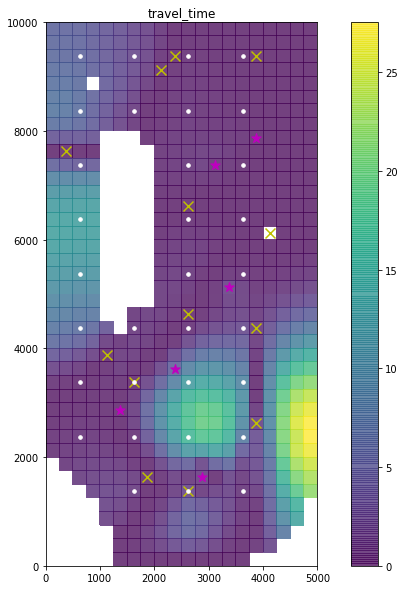

fa_headwaters_0001


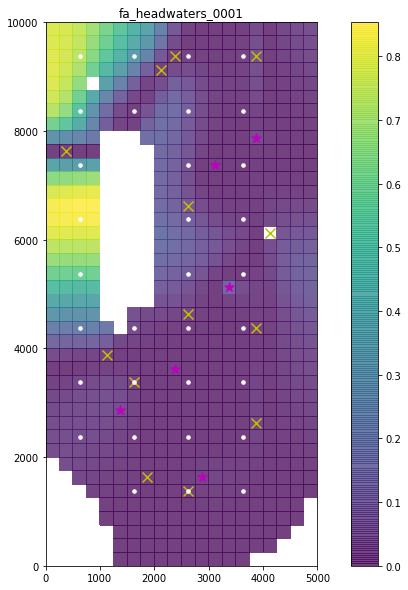

c001fr16c17_19791231


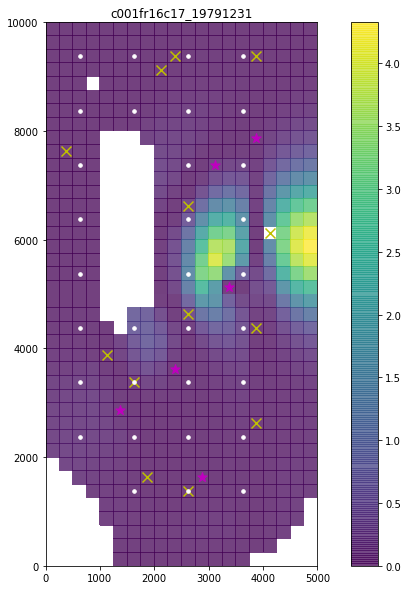

c001fr05c04_19791231


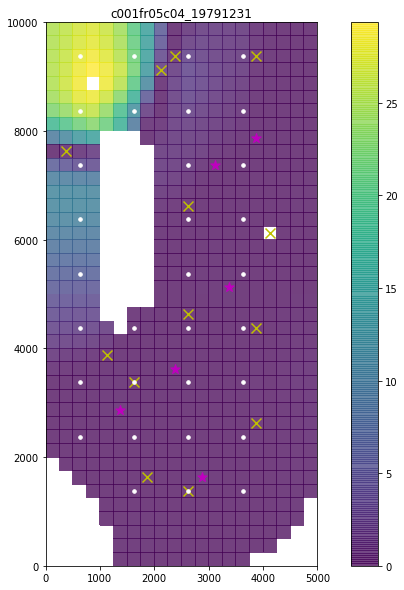

In [29]:
plot_added_worth(df_full)